# Golden Sample Comparison for Cutting Tool
### This is Notebook shoes different attempts to do a golden sample comparrison of cutting tools. Therefor images first have to be registered and transformed to than acutally be compared.

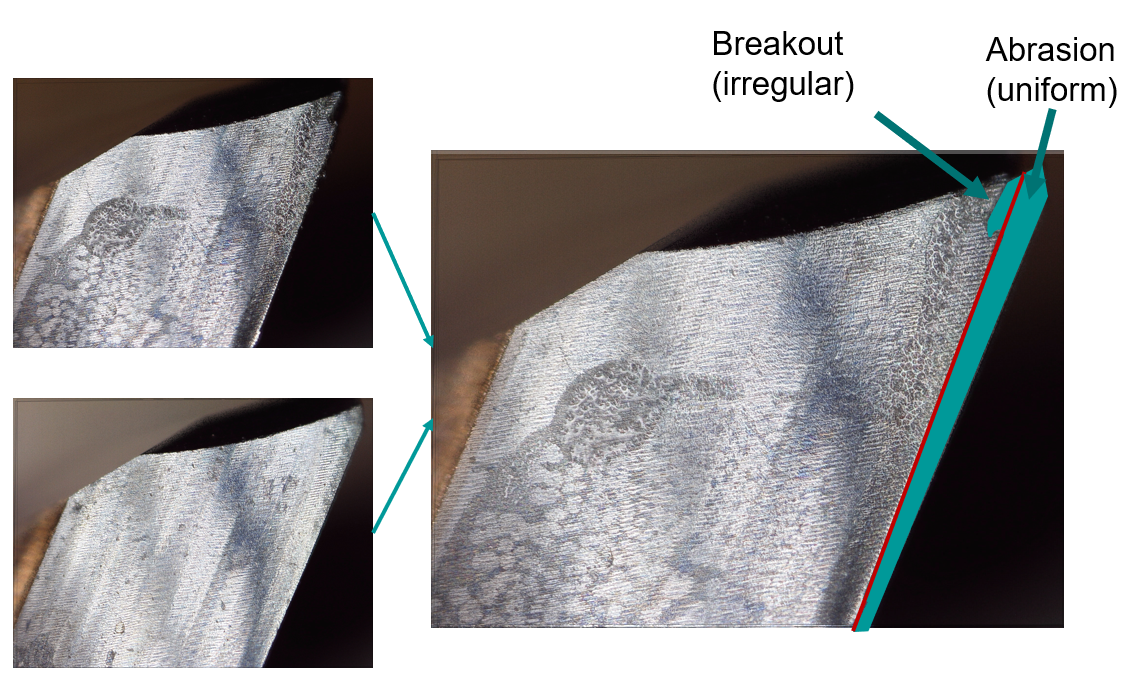

In [2]:
import os

from PIL import Image
from collections import defaultdict
import cv2
import numpy as np
import imutils
from skimage.metrics import structural_similarity as compare_ssim

scheme = Image.open('/home/ubuntu/deliverables/golden_sample.PNG')    

display(scheme)

#### Let us now try to compare between farthest images
We will compare between images of tool number(timestamp) 3 of the same edge and shaft (edge 3, shaft 1) from 03 and 30

In [3]:
earliest_pic_loc = "/home/ubuntu/deliverables/images/golden_sample.jpg"
latest_pic_loc   = "/home/ubuntu/deliverables/images/unaligned.jpg"

View the images

Tool before process


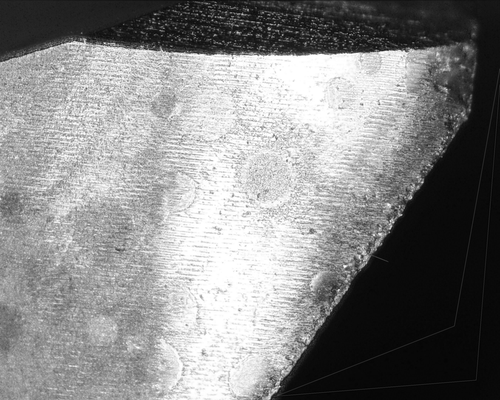

Tool after process


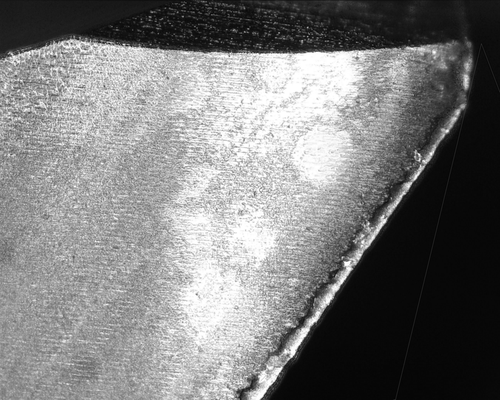

In [4]:

image1 = Image.open(earliest_pic_loc).resize((500,400),Image.ANTIALIAS)    
image2 = Image.open(latest_pic_loc).resize((500,400),Image.ANTIALIAS)    
print("Tool before process")
display(image1)
print("Tool after process")
display(image2)

### In the following several classical computer vision methods are implemented as funcitons

In [5]:
def get_grayscale_image(img):
    '''
    Returns opencv grayscale image object.
    '''
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
def get_blurred_image(img):
    '''
    Returns opencv blurred image object.
    '''
    return cv2.GaussianBlur(img, (3, 3), 0)

In [7]:
def get_eroded_image(img, iterations=3):
    '''
    Returns opencv eroded image object.
    '''
    return cv2.erode(img.copy(), None, iterations=iterations)

In [8]:
def get_binary_image(img):
    '''
    Returns opencv binary image after thresholding.
    '''
    t, bin_img = cv2.threshold(img, 40, 255, cv2.THRESH_BINARY)
    return bin_img

In [9]:
def get_image_edges(img):
    '''
    Returns opencv image object with Canny edge detection.
    '''
    return cv2.Canny(img, threshold1=75, threshold2=255)

In [10]:
def get_contoured_image(bin_img, org_img, contour_color=(0, 255, 255)):
    '''
    Returns opencv image object with contours.
    '''
    contours, hierarchy = cv2.findContours(image=bin_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # take the largest contour
    c = max(contours, key=cv2.contourArea)
    # draw it on the original image

        
    img_copy = org_img.copy()
    cv2.drawContours(img_copy, contours=c, contourIdx=-1, color=(255,0,255), thickness=5)
    return img_copy

In [11]:
def get_contoured_straight_image(bin_img, org_img, contour_color=(0, 255, 255)):
    '''
    Returns opencv image object with contours.
    '''
    contours, hierarchy = cv2.findContours(image=bin_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # take the largest contour
    c = max(contours, key=cv2.contourArea)
    # draw it on the original image
    from scipy.interpolate import splprep, splev
    import numpy

    smoothened = []
    x,y = c.T
    # Convert from numpy arrays to normal arrays
    x = x.tolist()[0]
    y = y.tolist()[0]
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splprep.html
    tck, u = splprep([x,y], u=None, s=0.01)
    # https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
    u_new = numpy.linspace(u.min(), u.max(), 150)
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splev.html
    x_new, y_new = splev(u_new, tck, der=0)
    # Convert it back to numpy format for opencv to be able to display it
    res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
    smoothened.append(numpy.asarray(res_array, dtype=numpy.int32))
        
    img_copy = org_img.copy()
    cv2.drawContours(img_copy, contours=smoothened, contourIdx=-1, color=(255,0,255), thickness=1)
    
    return img_copy

In [12]:
def display_two_images_overlayed(img1, img2):
    '''
    Displays one image overlayed on top of another.
    '''
    overlay = img1.copy()
    output  = img2.copy()
    cv2.addWeighted(overlay, 0.5, output, 0.5, 0, output)
    output = imutils.resize(output, 700)
    output = Image.fromarray(output)
    
    return output

 #### Image Processing Steps
 - Read the original image from location
 - Convert it to grayscale
 - Blur the grayscale image
 - Erode the blurred image
 - Convert the image to binary (black-background and white foreground) using thresholding
 - Get object edges using Canny edge detection (NOT REQUIRED)
 - Add contour to foreground object

In [13]:
def process_image(img_loc, contour_color):
    im       = cv2.imread(img_loc)
    img_gray = get_grayscale_image(im)
    blurred  = get_blurred_image(img_gray)
    eroded   = get_eroded_image(blurred)
    bin_img  = get_binary_image(eroded)
    edge_img = get_image_edges(bin_img)
    contours = get_contoured_image(bin_img, im, contour_color)

    return contours

## Next, we can try to do image registration and align the two pre-processed images

### Try 1: USe Enhanced Correlation Coefficient to register images and Affine transformation

Find the paper to the ECC (enhanced correlation coefficient) Algorithm here: https://ieeexplore.ieee.org/abstract/document/4515873




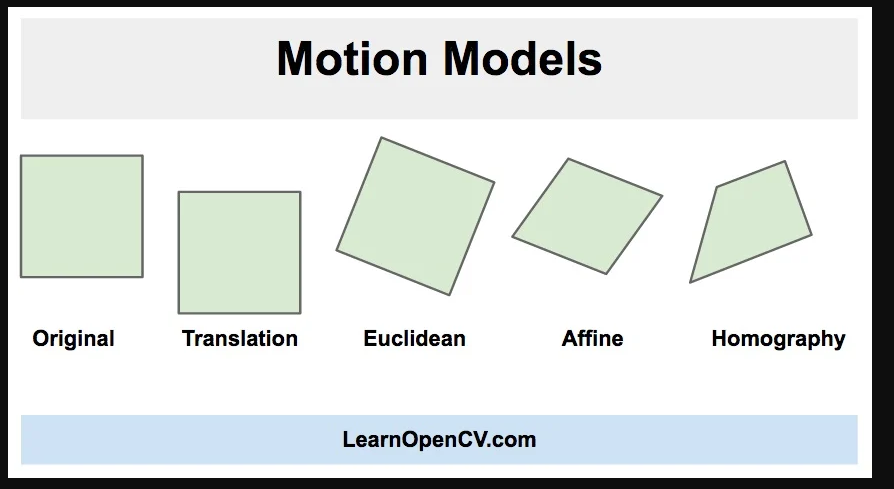

In [14]:

title =  Image.open(r'images/transformations.PNG')
display(title)


In [15]:
im1 = cv2.imread(earliest_pic_loc)
im2 = cv2.imread(latest_pic_loc)


# # Convert images to grayscale
im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

# Find size of image1
sz = im1.shape

# Define the motion model
warp_mode = cv2.MOTION_AFFINE

# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 500;

# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;

# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use warpPerspective for Homography
    im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    # Use warpAffine for Translation, Euclidean and Affine
    im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

##### Now that we have aligned the images, we will try to
 - Overlay the images on top of each other
 - Find the difference between the images

In [ ]:
bin1 = get_binary_image(im1)

for row in range(0, bin1.shape[0]):
    for col in range(0, bin1.shape[1]):
        if list(bin1[row, col]).count(0) != 3:
            bin1[row,col] = [255, 0, 0]

In [ ]:
bin2 = get_binary_image(im2_aligned)

for row in range(0, bin2.shape[0]):
    for col in range(0, bin2.shape[1]):
        if list(bin2[row, col]).count(0) != 3:
            bin2[row,col] = [0, 0, 255]

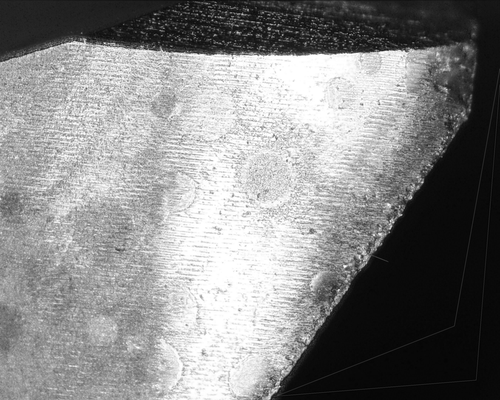

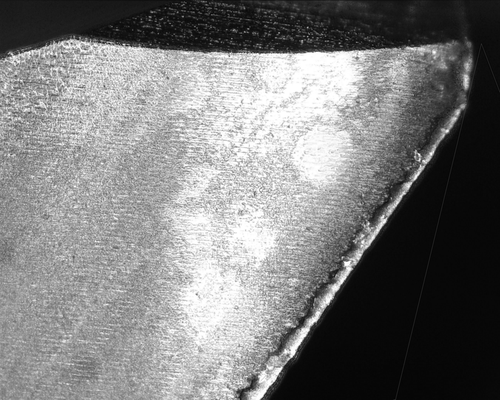

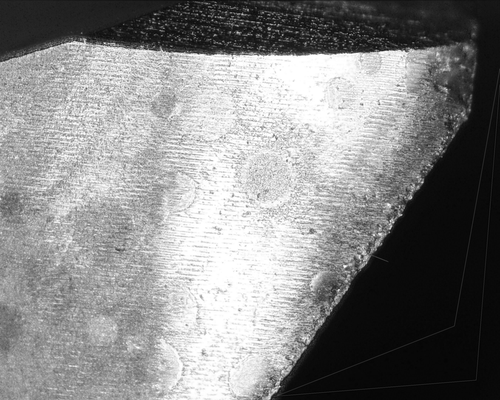

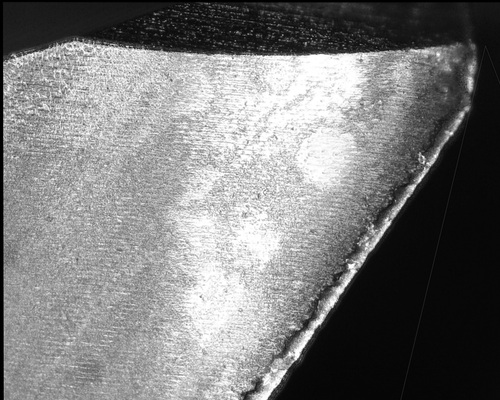

In [ ]:

from PIL import Image

image1 = Image.open(earliest_pic_loc).resize((500,400),Image.ANTIALIAS)    
image2 = Image.open(latest_pic_loc).resize((500,400),Image.ANTIALIAS)



display(image1,image2)

cv2.imwrite("aligned.jpg", im2_aligned)

image3 = Image.open(earliest_pic_loc).resize((500,400),Image.ANTIALIAS)    
image4 = Image.open("aligned.jpg").resize((500,400),Image.ANTIALIAS) 

display(image3,image4)




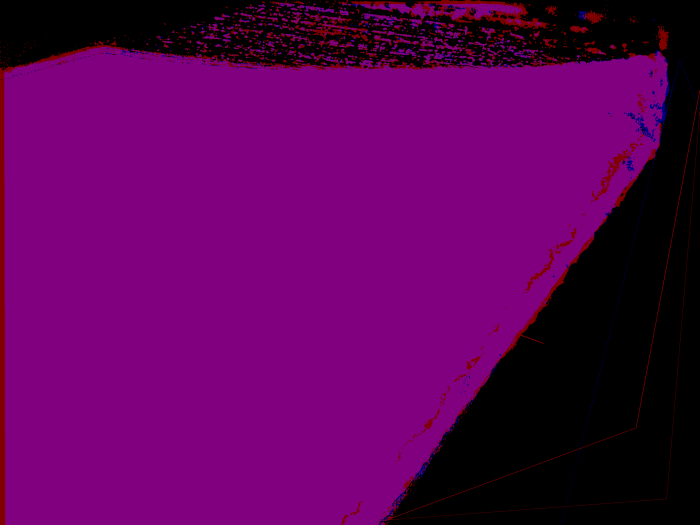

In [ ]:
overlayed = display_two_images_overlayed(bin2, bin1)

display(overlayed)

In [1]:
for row in range(0, overlayed.shape[0]):
    for col in range(0, overlayed.shape[1]):
        if list(overlayed[row, col]).count(128) == 1:
            overlayed[row,col] = [255, 0, 0]
        else:
            overlayed[row,col] = [0, 0, 0]
display(overlayed)

NameError: name 'overlayed' is not defined

### Idea 3: Using unly left uper part of image for template matching and Euclidean Transformation

Using the whole image could lead to a wrong motion of the image as the cutting edge has changed. 

In [ ]:
from IPython import display

im1 = cv2.imread(earliest_pic_loc)
im2 = cv2.imread(latest_pic_loc)

height, width, channels = im2.shape

im1_cut = im1[0:int(height/2.5), 0:int(width/1.3)]
im2_cut = im2[0:int(height/2.5),  0:int(width/1.3)]

display(im1_cut)

In [ ]:


# # Convert images to grayscale
im1_gray = cv2.cvtColor(im1_cut,cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2_cut,cv2.COLOR_BGR2GRAY)

# Find size of image1
sz = im1.shape

# Define the motion model
warp_mode= cv2.MOTION_EUCLIDEAN
#warp_mode = cv2.MOTION_AFFINE

# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 500;

# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;

# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use warpPerspective for Homography
    im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    # Use warpAffine for Translation, Euclidean and Affine
    im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

In [ ]:
bin1 = get_binary_image(im1)

for row in range(0, bin1.shape[0]):
    for col in range(0, bin1.shape[1]):
        if list(bin1[row, col]).count(0) != 3:
            bin1[row,col] = [255, 0, 0]

In [ ]:
bin2 = get_binary_image(im2_aligned)

for row in range(0, bin2.shape[0]):
    for col in range(0, bin2.shape[1]):
        if list(bin2[row, col]).count(0) != 3:
            bin2[row,col] = [0, 0, 255]

In [ ]:
# display_two_images_side_by_side(cv2.imread(earliest_pic_loc), cv2.imread(latest_pic_loc))

# display_two_images_side_by_side(cv2.imread(latest_pic_loc), im2_aligned)

cv2.imwrite("aligned.jpg", im2_aligned)
cv2.imwrite("golden_sample.jpg", im1)

display(bin1)
display(bin2)


Comparing the alignment results with diffchecker.de have shown that the translation by calculating the warp matrix without the cutting edge part in the image differ from the one done with the whole image. This leads to the assumption that the one done on the whole image is incorrect as it is also trying to match the cutting edges which are not neccsarrely the same anymore. 

Furthermore the affine transformation is expected to be wrong as some artefacts found in image earliest_pic_loc = data_dict["03"]["5"]["3"][0] and latest_pic_loc   = data_dict["30"]["5"]["3"][0] are not aligning after transformation. On the other hand pure euclidean transformation leads to a match of these artefacts. 

The euclidean transformation ignores that the cutting tool could be slightly rotated around the x axes of the image. 

In [ ]:
from __future__ import division
from __future__ import print_function
from calendar import c
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from IPython.html.widgets import interact, fixed

plt.rcParams["figure.figsize"] = (10,8)

a = plt.imread("aligned.jpg")
b = plt.imread("golden_sample.jpg")
c = plt.imread(latest_pic_loc)
d = plt.imread("golden_sample.jpg")

def c_blend(a, b, alpha):
    """Blend images a and b.
    """
    return (1.0-alpha)*a + alpha*b


def c_diff(a, b, alpha):
    """Return the difference between a and b.
    """
    return a-b


def c_horizontal_shade(a, b, alpha):
    """Form c from top rows of a and bottom rows of b.
    """
    nrows = a.shape[0]
    print(nrows)
    r_index = int(alpha*nrows)
    print(r_index)
    c = np.empty_like(a)
    c[:r_index] = a[:r_index]
    c[r_index:] = b[r_index:]

    return c


def c_vertical_shade(a, b, alpha):
    """Form c from left columns of a and right columns of b.
    """
    ncols = a.shape[1]
    c_index = int(alpha*ncols)
    c = np.empty_like(a)   
    c[:, :c_index] = a[:, :c_index]
    c[:, c_index:] = b[:, c_index:]
    return c


def compare(a, b, method=c_vertical_shade, alpha=0.5):
    """Show the comparison between images a and b using the 
    selected comparison method.
    """
    c = method(a, b, alpha)
    cmin = min(a.min(), b.min())
    cmax = max(a.max(), b.max())
    x = plt.imshow(c, clim=(cmin, cmax))

 

interact(compare, a=fixed(a), b=fixed(b), alpha=(0.0, 1.0,0.01), 
         method=dict(blend=c_blend, diff=c_diff, 
                     horizontal_shade=c_horizontal_shade,
                     vertical_shade=c_vertical_shade));

                
interact(compare, a=fixed(c), b=fixed(d), alpha=(0.0, 1.0,0.01), 
         method=dict(blend=c_blend, diff=c_diff, 
                     horizontal_shade=c_horizontal_shade,
                     vertical_shade=c_vertical_shade));

c:\Users\z0049njv\Anaconda3\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


interactive(children=(Dropdown(description='method', index=3, options={'blend': <function c_blend at 0x0000022…

interactive(children=(Dropdown(description='method', index=3, options={'blend': <function c_blend at 0x0000022…

In [ ]:
overlayed = display_two_images_overlayed(bin2, bin1)

In [ ]:


from pickletools import uint8


def process_image(img_loc, contour_color):
   
    img_gray = get_grayscale_image(img_loc)
    eroded   = get_eroded_image(img_gray)
    display(eroded)
    ret, thresh = cv2.threshold(eroded, 20, 255, cv2.THRESH_BINARY)
    eroded   = get_eroded_image(img_gray)
    #bin_img  = get_binary_image(eroded)
    #edge_img = get_image_edges(bin_img)
    contours = get_contoured_image(thresh, eroded, contour_color)

    return contours 

def delete_small(img,min):

    # find all of the connected components (white blobs in your image).
    # im_with_separated_blobs is an image where each detected blob has a different pixel value ranging from 1 to nb_blobs - 1.
    nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(img)
    # stats (and the silenced output centroids) gives some information about the blobs. See the docs for more information. 
    # here, we're interested only in the size of the blobs, contained in the last column of stats.
    sizes = stats[:, -1]
    # the following lines result in taking out the background which is also considered a component, which I find for most applications to not be the expected output.
    # you may also keep the results as they are by commenting out the following lines. You'll have to update the ranges in the for loop below. 
    sizes = sizes[1:]
    nb_blobs -= 1

    # minimum size of particles we want to keep (number of pixels).
    # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever.
    min_size = min 

    # output image with only the kept components
    im_result = np.zeros((img.shape))
    # for every component in the image, keep it only if it's above min_size
    for blob in range(nb_blobs):
        if sizes[blob] >= min_size:
            # see description of im_with_separated_blobs above
            im_result[im_with_separated_blobs == blob + 1] = 255

    return im_result


bin1 = get_binary_image(im1)
display(bin1)
img_black = get_grayscale_image(bin1)
display(img_black)
im_result = delete_small(img_black,55000)
display(im_result)
img_white = im_result
img_white = (255-img_white)
img_white = get_binary_image(img_white)
display(img_white)
print(img_white)
img_white = img_white.astype(np.uint8)
im_result = delete_small(img_white,55000)
display(im_result)

contours, hierarchy = cv2.findContours(image=im_result.astype(np.uint8), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
c = max(contours, key=cv2.contourArea)

#epsilon = 0.002*cv2.arcLength(c,True)
approx = cv2.approxPolyDP(c,epsilon,True)
img_copy = im1.copy()
img_copy_2 = im1.copy()
hull = []
hull.append(cv2.convexHull(c, True))
drawing = np.zeros((im1.shape[0], im1.shape[1], 3), np.uint8)
cv2.drawContours(img_copy, hull, contourIdx=-1, color=(255,0,255), thickness=10)
cv2.drawContours(drawing, [approx], contourIdx=-1, color=(255,0,255), thickness=10)
cv2.drawContours(img_copy_2, c, contourIdx=-1, color=(255,0,255), thickness=10)


f, axarr = plt.subplots(2,2,figsize=(50,90))
figsize=(12, 12)
axarr[0,0].imshow(im_result)
axarr[0,1].imshow(img_copy)
axarr[1,0].imshow(img_copy_2)
axarr[1,1].imshow(drawing)

[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [  0.   0.   0. ... 255. 255. 255.]
 [  0.   0.   0. ... 255. 255. 255.]
 [  0.   0.   0. ... 255. 255. 255.]]


NameError: name 'epsilon' is not defined

In [ ]:
for row in range(0, overlayed.shape[0]):
    for col in range(0, overlayed.shape[1]):
        if list(overlayed[row, col]).count(128) == 1:
            overlayed[row,col] = [255, 0, 0]
        else:
            overlayed[row,col] = [0, 0, 0]
display(overlayed)

### Saliency Detection

Not robust

In [ ]:

import argparse
import cv2
# construct the argument parser and parse the arguments

# load the input image
image = cv2.imread(earliest_pic_loc)
#path = r"C:\UserData\z0049njv\OneDrive - Siemens AG\Datasets\Images\Bad_Neustadt\20210419_BadNeustadt\15_1_4.png"
#image = cv2.imread(path)
# saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
# (success, saliencyMap) = saliency.computeSaliency(image)
# saliencyMap = (saliencyMap * 255).astype("uint8")
# cv2.imshow("Image", image)
# cv2.imshow("Output", saliencyMap)
# cv2.waitKey(0)

# compute the saliency map
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(image)
# if we would like a *binary* map that we could process for contours,
# compute convex hull's, extract bounding boxes, etc., we can
# additionally threshold the saliency map
threshMap = cv2.threshold((saliencyMap*255).astype("uint8"), 40, 255,
	cv2.THRESH_BINARY)[1]
# show the images
image = cv2.resize(image, (400, 400))    
saliencyMap = cv2.resize(saliencyMap, (400, 400))   
threshMap = cv2.resize(threshMap, (400, 400))   
cv2.imshow("Image", image)
cv2.imshow("Output", saliencyMap)
cv2.imshow("Thresh", threshMap)
cv2.waitKey(0)

-1

In [ ]:
import imutils
import time
import cv2

while True:
	# grab the frame from the threaded video stream and resize it
	# to 500px (to speedup processing)
	
	frame = cv2.imread(earliest_pic_loc)
	frame = imutils.resize(frame, width=500)
	# if our saliency object is None, we need to instantiate it
	if saliency is None:
		saliency = cv2.saliency.MotionSaliencyBinWangApr2014_create()
		saliency.setImagesize(frame.shape[1], frame.shape[0])
		saliency.init()

		# convert the input frame to grayscale and compute the saliency
	# map based on the motion model
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	(success, saliencyMap) = saliency.computeSaliency(gray)
	saliencyMap = (saliencyMap * 255).astype("uint8")
	# display the image to our screen
	cv2.imshow("Frame", frame)
	cv2.imshow("Map", saliencyMap)
	key = cv2.waitKey(1) & 0xFF
 
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

KeyboardInterrupt: 

: 

uint8
uint8
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]]


-1

In [ ]:
import numpy as np
import cv2 as cv
import cv2 as cv2
from matplotlib import pyplot as plt
from skimage.segmentation import watershed

def delete_small(img,min):
    img = (255-img)
    # find all of the connected components (white blobs in your image).
    # im_with_separated_blobs is an image where each detected blob has a different pixel value ranging from 1 to nb_blobs - 1.
    nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(img)
    # stats (and the silenced output centroids) gives some information about the blobs. See the docs for more information. 
    # here, we're interested only in the size of the blobs, contained in the last column of stats.
    sizes = stats[:, -1]
    # the following lines result in taking out the background which is also considered a component, which I find for most applications to not be the expected output.
    # you may also keep the results as they are by commenting out the following lines. You'll have to update the ranges in the for loop below. 
    sizes = sizes[1:]
    nb_blobs -= 1

    # minimum size of particles we want to keep (number of pixels).
    # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever.
    min_size = min 

    # output image with only the kept components
    im_result = np.zeros((img.shape))
    # for every component in the image, keep it only if it's above min_size
    for blob in range(nb_blobs):
        if sizes[blob] >= min_size:
            # see description of im_with_separated_blobs above
            im_result[im_with_separated_blobs == blob + 1] = 255
    im_result = (255-im_result)
    return im_result


img = cv.imread(r'C:\UserData\z0049njv\OneDrive - Siemens AG\Datasets\Versuch_3\30\tool_2022-04-08-23-04-09/edge_3_shaft_2.jpg')

img = cv.resize(img, (800, 800)  )
img_org = img
img_org_2 = img.copy()
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,60,255,cv.THRESH_BINARY)

cv.imshow("thresh", thresh)
cv.waitKey(0)

# noise removal

thresh = delete_small(thresh,4000)
cv.imshow("thresh", thresh)
cv.waitKey(0)
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 6)

cv.imshow("opening", opening)
cv.waitKey(0)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=10)

cv.imshow("sure_bg", sure_bg)
cv.waitKey(0)
# Finding sure foreground area
# dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
# ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
sure_fg = cv.erode(opening, None, iterations=10)
sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)
print(sure_fg.dtype)
print(sure_bg.dtype)
unknown = cv.subtract(sure_bg,sure_fg)

cv.imshow("sure_fg", sure_fg)
cv.waitKey(0)

cv.imshow("unknown", unknown)
cv.waitKey(0)
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
print(markers)

markers = cv.watershed(img,markers)

img[markers==3] = [255,255,255]
img[markers==2] = [255,255,255]
img[markers==1] = [0,0,0]
img_org[markers==-1] = [255,0,0]
cv.imshow("jo", img_org)
cv.waitKey(0)

img_copy = img.copy()
img_copy = cv.cvtColor(img_copy,cv.COLOR_BGR2GRAY)
ret, im = cv.threshold(img_copy,40,255,cv.THRESH_BINARY)
cv.imshow("gray", im)
cv.waitKey(0)
contours = get_contoured_straight_image(im, img_org_2, (255,0,0))
cv.imshow("contours", contours)
cv.waitKey(0)

In [ ]:
import numpy as np
import cv2 as cv
import cv2 as cv2
from matplotlib import pyplot as plt
from skimage.segmentation import watershed

def delete_small(img,min):
    img = (255-img)
    # find all of the connected components (white blobs in your image).
    # im_with_separated_blobs is an image where each detected blob has a different pixel value ranging from 1 to nb_blobs - 1.
    nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(img)
    # stats (and the silenced output centroids) gives some information about the blobs. See the docs for more information. 
    # here, we're interested only in the size of the blobs, contained in the last column of stats.
    sizes = stats[:, -1]
    # the following lines result in taking out the background which is also considered a component, which I find for most applications to not be the expected output.
    # you may also keep the results as they are by commenting out the following lines. You'll have to update the ranges in the for loop below. 
    sizes = sizes[1:]
    nb_blobs -= 1

    # minimum size of particles we want to keep (number of pixels).
    # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever.
    min_size = min 

    # output image with only the kept components
    im_result = np.zeros((img.shape))
    # for every component in the image, keep it only if it's above min_size
    for blob in range(nb_blobs):
        if sizes[blob] >= min_size:
            # see description of im_with_separated_blobs above
            im_result[im_with_separated_blobs == blob + 1] = 255
    im_result = (255-im_result)
    return im_result


img = cv.imread(r'C:\UserData\z0049njv\OneDrive - Siemens AG\Datasets\Versuch_3\30\tool_2022-04-08-23-04-09/edge_3_shaft_2.jpg')

img = cv.resize(img, (800, 800)  )
img_org = img
img_org_2 = img.copy()
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,60,255,cv.THRESH_BINARY)

cv.imshow("thresh", thresh)
cv.waitKey(0)

# noise removal

thresh = delete_small(thresh,4000)
cv.imshow("thresh", thresh)
cv.waitKey(0)
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 6)

cv.imshow("opening", opening)
cv.waitKey(0)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=10)

cv.imshow("sure_bg", sure_bg)
cv.waitKey(0)
# Finding sure foreground area
# dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
# ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
sure_fg = cv.erode(opening, None, iterations=10)
sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)

unknown = cv.subtract(sure_bg,sure_fg)

cv.imshow("sure_fg", sure_fg)
cv.waitKey(0)

cv.imshow("unknown", unknown)
cv.waitKey(0)
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
print(markers.shape)
# Add one to all labels so that sure background is not 0, but 1

# Now, mark the region of unknown with zero
markers[:] = 0
print(markers)

#markers = np.zeros((markers.shape))

markers[500:750,500:750] = 1
markers[100:200,100:200] = 2

markers = markers+1
print(markers.dtype)
print(markers)
markers = cv.watershed(img,markers)


img[markers==3] = [255,255,255]
img[markers==2] = [255,0,0]
img[markers==1] = [0,0,0]

cv.imshow("jo", img)
cv.waitKey(0)

img_copy = img.copy()
img_copy = cv.cvtColor(img_copy,cv.COLOR_BGR2GRAY)
ret, im = cv.threshold(img_copy,40,255,cv.THRESH_BINARY)
cv.imshow("gray", im)
cv.waitKey(0)
contours = get_contoured_straight_image(im, img_org_2, (255,0,0))
cv.imshow("contours", contours)
cv.waitKey(0)

(800, 800)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
int32
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


-1